<a href="https://colab.research.google.com/github/IlyasMoutawwakil/ONNX-TrOCR/blob/main/TrOCR-ONNXization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

!pip install transformers
!pip install sentencepiece
!pip install onnxruntime-gpu
!pip install protobuf
!pip install torch
!pip install onnx

# HF model

In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocessor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-stage1')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1').to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# generator configuration
# model.config.decoder_start_token_id = preprocessor.tokenizer.cls_token_id # if you're gonna train the model
model.config.pad_token_id = preprocessor.tokenizer.pad_token_id
model.config.eos_token_id = preprocessor.tokenizer.sep_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.max_length = 96
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 1 # keep it simple

--2022-09-21 11:12:49--  https://openreferral.org/wp-content/uploads/2016/07/CTLhiresLogo.png
Resolving openreferral.org (openreferral.org)... 172.67.132.239, 104.21.5.39, 2606:4700:3034::6815:527, ...
Connecting to openreferral.org (openreferral.org)|172.67.132.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33245 (32K) [image/png]
Saving to: ‘CTLhiresLogo.png.5’

CTLhiresLogo.png.5  100%[===================>]  32.47K  --.-KB/s    in 0s      

2022-09-21 11:12:49 (113 MB/s) - ‘CTLhiresLogo.png.5’ saved [33245/33245]



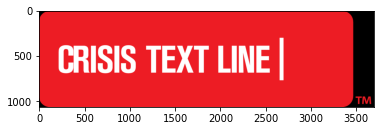

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

! wget "https://openreferral.org/wp-content/uploads/2016/07/CTLhiresLogo.png"

line_image = Image.open("CTLhiresLogo.png").convert("RGB")
plt.imshow(line_image)
plt.show()

line_images = [line_image for i in range(10)]

In [ ]:
pixel_values = preprocessor.feature_extractor(
  line_images,
  return_tensors="pt"
).pixel_values.to(device)

preprocessor.tokenizer.batch_decode(model.generate(pixel_values), skip_special_tokens=True)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1232: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 96 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


['GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'CRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |']

## A little bit more optimized way to compute
Here we order lines with an heuristic function so that the lines that have the same length are grouped together.

In [ ]:
# sorted_line_images = sorted(line_images, key=lambda line : line.size[0]/line.size[1])
# sorted_pixel_values = preprocessor.feature_extractor(
#   sorted_line_images,
#   return_tensors="pt"
#   ).pixel_values.to(device)

# batching_step = 4
# sum([preprocessor.tokenizer.batch_decode(model.generate(sorted_pixel_values[i:i+batching_step]), skip_special_tokens=True) for i in range(0, len(sorted_pixel_values), batching_step)], [])

# Container models

In [ ]:
import torch

class TrOCREncoder(torch.nn.Module):
    """ Creation of a class to output only the last hidden state from the encoder """

    def __init__(self, encoder, config):
        super().__init__()
        self.model = encoder
        self.config = config
        
    def forward(self, *inputs, **kwargs):
        return self.model(*inputs, **kwargs)

class TrOCRDecoder(torch.nn.Module):
    """ Creation of a class to combine the decoder and the lm head """

    def __init__(self, decoder, config):
        super().__init__()
        self.model = decoder
        self.config = config

    def forward(self, *inputs, **kwargs):
        return self.model(*inputs, **kwargs)

In [ ]:
simplified_encoder = TrOCREncoder(model.encoder, model.encoder.config)
simplified_decoder = TrOCRDecoder(model.decoder, model.decoder.config)

# ONNXization

In [ ]:
from pathlib import Path

with torch.no_grad():
    torch.onnx.export(
        simplified_encoder,
        args=torch.ones([64, 3, 384, 384]).to(device),
        f=Path('/content/trocr_encoder.onnx'),
        opset_version=15,
        input_names=["pixel_values"],
        output_names=["last_hidden_state"],
        dynamic_axes={
            "pixel_values": {0:'batch'},
            "last_hidden_state": {0: 'batch'},
        },
        do_constant_folding=True,
    )

/usr/local/lib/python3.7/dist-packages/transformers/models/vit/modeling_vit.py:166: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.7/dist-packages/transformers/models/vit/modeling_vit.py:171: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


In [ ]:
input_ids = torch.ones(64, 96, dtype=torch.int64).to(device)
attention_mask = torch.ones(64, 96, dtype=torch.int64).to(device)
encoder_hidden_states  = torch.ones([64, 577, 768]).to(device)

with torch.no_grad():
    torch.onnx.export(
        simplified_decoder,
        args=(input_ids, attention_mask, encoder_hidden_states),
        f=Path('/content/trocr_decoder.onnx'),
        opset_version=15,
        input_names=[
            "input_ids",
            "attention_mask",
            "encoder_hidden_states",
        ],
        output_names=["logits"],
        dynamic_axes={
            "input_ids": {0:'batch', 1:'sequence_length'},
            "attention_mask": {0:'batch', 1:'sequence_length'},
            "encoder_hidden_states": {0:'batch'},
            "logits": {0:'batch'},
        },
        do_constant_folding=True,
    )

/usr/local/lib/python3.7/dist-packages/transformers/models/trocr/modeling_trocr.py:141: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.weights is None or max_pos > self.weights.size(0):
/usr/local/lib/python3.7/dist-packages/transformers/models/trocr/modeling_trocr.py:526: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1:
/usr/local/lib/python3.7/dist-packages/transformers/models/trocr/modeling_trocr.py:53: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you 

In [ ]:
onnx_models = (Path('/content/trocr_encoder.onnx'),
               Path('/content/trocr_decoder.onnx'))

# Quantization

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType
from pathlib import Path

def quantize(models_paths):
    """
    Quantize the weights of the model from float32 to in8 to allow very efficient inference on modern CPU
    Uses unsigned ints for activation values, signed ints for weights, per
    https://onnxruntime.ai/docs/performance/quantization.html#data-type-selection
    it is faster on most CPU architectures
    Args:
        onnx_model_path: Path to location the exported ONNX model is stored
    Returns: The Path generated for the quantized
    """

    quant_models_paths = []
    for model_path in models_paths:
      
        model_path = model_path.as_posix()
        output_model_path = f"{model_path[:-5]}_quantized.onnx"
        
        quantize_dynamic(
            model_input=model_path,
            model_output=output_model_path,
            per_channel=True,
            reduce_range=True, # should be the same as per_channel
            weight_type=QuantType.QUInt8, # per docs, signed is faster on most CPUs
            optimize_model=True,
        )
        quant_models_paths.append(output_model_path)

    return tuple(quant_models_paths)

quantized_models_paths = quantize(models_paths=onnx_models)
quantized_models_paths

# ONNX Runtime Sessions

In [ ]:
import os
from onnxruntime import (
    GraphOptimizationLevel,
    InferenceSession,
    SessionOptions,
    ExecutionMode,
)

def get_onnx_runtime_sessions(
    model_paths,
    default: bool = True,
    opt_level: int = 99,
    parallel_exe_mode: bool = True,
    n_threads: int = 0,
    provider=["TensorrtExecutionProvider", "CPUExecutionProvider", "CUDAExecutionProvider"]
):
    path_to_encoder, path_to_decoder = model_paths
    
    if default:
        encoder_sess = InferenceSession(str(path_to_encoder), providers=provider)
        decoder_sess = InferenceSession(str(path_to_decoder), providers=provider)
    else:
        # Few properties that might have an impact on performances
        options = SessionOptions()
        if opt_level == 1:
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_BASIC
        elif opt_level == 2:
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_EXTENDED
        else:
            assert opt_level == 99
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

        # set this true for better performance
        if parallel_exe_mode == True:
            options.execution_mode = ExecutionMode.ORT_PARALLEL
        else:
            options.execution_mode = ExecutionMode.ORT_SEQUENTIAL

        encoder_sess = InferenceSession(str(path_to_encoder), options, providers=provider)
        decoder_sess = InferenceSession(str(path_to_decoder), options, providers=provider)

    return encoder_sess, decoder_sess
  
encoder_sess, decoder_sess = get_onnx_runtime_sessions(
  model_paths=onnx_models,
  default=True,
  provider=['TensorrtExecutionProvider']
)

# Inferencing

In [ ]:
import torch
import numpy as np
from transformers.modeling_outputs import BaseModelOutput

class ONNXTrOCREncoder(torch.nn.Module):
    def __init__(self, encoder_sess):
        super().__init__()
        self.encoder = encoder_sess
        self.main_input_name = 'pixel_values'

    def forward(
        self,
        pixel_values,
        *args, **kwargs
    ):
        last_hidden_state = torch.from_numpy(
            self.encoder.run(
                ["last_hidden_state"],
                {
                    "pixel_values": pixel_values.cpu().numpy(),
                },
            )[0])
        
        return BaseModelOutput(last_hidden_state=last_hidden_state)

onnx_encoder = ONNXTrOCREncoder(encoder_sess)
hidden_state = onnx_encoder(torch.ones([2, 3, 384, 384]).to(device))
hidden_state[0].shape

torch.Size([2, 577, 768])

In [ ]:
from transformers.modeling_outputs import Seq2SeqLMOutput

class ONNXTrOCRDecoder(torch.nn.Module):
    def __init__(self, decoder_sess):
        super().__init__()
        self.decoder = decoder_sess
    
    def prepare_inputs_for_generation(self, input_ids, past=None, attention_mask=None, use_cache=None, **kwargs):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_ids.shape)

        return {
            "input_ids": input_ids,  # encoder_outputs is defined. input_ids not needed
            "attention_mask": attention_mask,
            "past_key_values": past,
            "use_cache": use_cache,
        }
    
    def forward(self, input_ids, attention_mask, encoder_hidden_states, *args, **kwargs):
        decoder_outputs = torch.from_numpy(self.decoder.run(
            ["logits"],
            {
                "input_ids": input_ids.cpu().numpy(),
                "attention_mask": attention_mask.cpu().numpy(),
                "encoder_hidden_states": encoder_hidden_states.cpu().numpy(),
            },
        )[0])
        
        return Seq2SeqLMOutput(logits=decoder_outputs)

input_ids = torch.ones(2, 96, dtype=torch.int64).to(device)
attention_mask = torch.ones(2, 96, dtype=torch.int64).to(device)
encoder_hidden_states  = torch.ones([2, 577, 768]).to(device)

onnx_decoder = ONNXTrOCRDecoder(decoder_sess)
decoder_logits = onnx_decoder(input_ids, attention_mask, encoder_hidden_states)
decoder_logits[0].shape

torch.Size([2, 96, 50265])

In [ ]:
from transformers import AutoConfig

class ONNXTrOCR(VisionEncoderDecoderModel):
    """creates a T5 model using onnx sessions (encode, decoder & init_decoder)"""

    def __init__(self, model_path, onnx_model_sessions):
        config = AutoConfig.from_pretrained(model_path)
        super().__init__(config)
        
        encoder_sess, decoder_sess = onnx_model_sessions

        self.encoder = ONNXTrOCREncoder(encoder_sess)
        self.decoder = ONNXTrOCRDecoder(decoder_sess)

    def forward(
        self,
        pixel_values=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):
        encoder_hidden_states = encoder_outputs['last_hidden_state'] \
                                 if type(encoder_outputs)==dict \
                                 else encoder_outputs[0]

        # else:
        encoder_attention_mask = None
        
        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            use_cache=use_cache,
            past_key_values=past_key_values,
        )

        return Seq2SeqLMOutput(
            logits=decoder_outputs.logits,
        )

onnx_trocr = ONNXTrOCR(model_path='microsoft/trocr-base-stage1', 
                       onnx_model_sessions=(encoder_sess, decoder_sess)).to(device)

# tokens
# onnx_trocr.config.decoder_start_token_id = preprocessor.tokenizer.cls_token_id
onnx_trocr.config.pad_token_id = preprocessor.tokenizer.pad_token_id
onnx_trocr.config.eos_token_id = preprocessor.tokenizer.sep_token_id
# make sure vocab size is set correctly
onnx_trocr.config.vocab_size = onnx_trocr.config.decoder.vocab_size
# set beam search parameters
onnx_trocr.config.max_length = 96
onnx_trocr.config.early_stopping = True
onnx_trocr.config.no_repeat_ngram_size = 3
onnx_trocr.config.length_penalty = 2.0
onnx_trocr.config.num_beams = 1

In [ ]:
preprocessor.tokenizer.batch_decode(
  onnx_trocr.generate(pixel_values.to('cpu')), 
  skip_special_tokens=True)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1232: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 96 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


['GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |']

In [ ]:
from transformers import AutoConfig

class BetterONNXTrOCR(VisionEncoderDecoderModel):
    """creates a T5 model using onnx sessions (encode, decoder & init_decoder)"""

    def __init__(self, model_path, onnx_model_sessions):
        config = AutoConfig.from_pretrained(model_path)
        super().__init__(config)
        
        encoder_sess, decoder_sess = onnx_model_sessions

        self.encoder = ONNXTrOCREncoder(encoder_sess)
        self.decoder = ONNXTrOCRDecoder(decoder_sess)

    def forward(
        self,
        pixel_values=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):
        encoder_hidden_states = encoder_outputs['last_hidden_state'] \
                                 if type(encoder_outputs)==dict \
                                 else encoder_outputs[0]

        encoder_attention_mask = None
        
        eos_mask = decoder_input_ids[:, -1] <= self.config.eos_token_id
        # Decode        
        if any(eos_mask) and (decoder_input_ids.shape[1]>1):
            reduced_logits = self.decoder(
                input_ids=decoder_input_ids[torch.logical_not(eos_mask), :],
                attention_mask=decoder_attention_mask,
                encoder_hidden_states=encoder_hidden_states[torch.logical_not(eos_mask), :, :],
                encoder_attention_mask=encoder_attention_mask,
                inputs_embeds=decoder_inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                use_cache=use_cache,
                past_key_values=past_key_values,
            ).logits
            logits = torch.full((decoder_input_ids.shape[0], decoder_input_ids.shape[1], self.config.decoder.vocab_size), fill_value=self.config.pad_token_id, dtype=reduced_logits.dtype, device=reduced_logits.device)
            logits[torch.logical_not(eos_mask), :, :] = reduced_logits
            logits[eos_mask, :, :] = self.ids_to_logits(decoder_input_ids[eos_mask, 1:], reduced_logits)
        else:
            logits = self.decoder(
                input_ids=decoder_input_ids,
                attention_mask=decoder_attention_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                inputs_embeds=decoder_inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                use_cache=use_cache,
                past_key_values=past_key_values,
            ).logits
        
        return Seq2SeqLMOutput(
          logits=logits,
        )

    def ids_to_logits(self, ids, reduced_logits):
        logits = torch.zeros((ids.shape[0], ids.shape[1]+1, self.config.decoder.vocab_size), dtype=reduced_logits.dtype, device=reduced_logits.device)
        logits[:, -1, 2] = 1 # max_pad_token
        for i in range(ids.shape[1]):
            logits[:, i, ids[:, i]] = 1
        
        return logits

better_onnx_trocr = BetterONNXTrOCR(model_path='microsoft/trocr-base-stage1', 
                       onnx_model_sessions=(encoder_sess, decoder_sess))

# onnx_trocr.config.decoder_start_token_id = preprocessor.tokenizer.cls_token_id
better_onnx_trocr.config.pad_token_id = preprocessor.tokenizer.pad_token_id
better_onnx_trocr.config.eos_token_id = preprocessor.tokenizer.sep_token_id
# make sure vocab size is set correctly
better_onnx_trocr.config.vocab_size = better_onnx_trocr.config.decoder.vocab_size
# set beam search parameters
better_onnx_trocr.config.max_length = 96
better_onnx_trocr.config.early_stopping = True
better_onnx_trocr.config.no_repeat_ngram_size = 3
better_onnx_trocr.config.length_penalty = 2.0
better_onnx_trocr.config.num_beams = 1

In [ ]:
preprocessor.tokenizer.batch_decode(
  better_onnx_trocr.generate(pixel_values.to('cpu')), 
  skip_special_tokens=True)

['GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |',
 'GRISIS TEXT LINE |']